# __DTSC 5301 - Final Project Report - Clean Energy__
### By: Daniel Knopp, Peter LeCavalier, Ryan Hensel, Kenzie Hensel, Sierra Rose
**Question of Interest**
<div class="alert alert-block alert-info">
Will Clean Energy Ever Match Total Energy Consumption in the US?
</div>

**Data Source**
<div class="alert alert-block alert-info">
INSERT DATA DESCRIPTION HERE
</div>

**Initial Approach**
<div class="alert alert-block alert-info">
INSERT HERE
</div>

In [2]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# import annual energy production by source data
e_production_by_source = pd.read_csv('annual_e_prod_by_source.csv')

# import annual energy consumption by source data
e_consumption_by_source = pd.read_csv('annual_e_cons_by_source.csv')

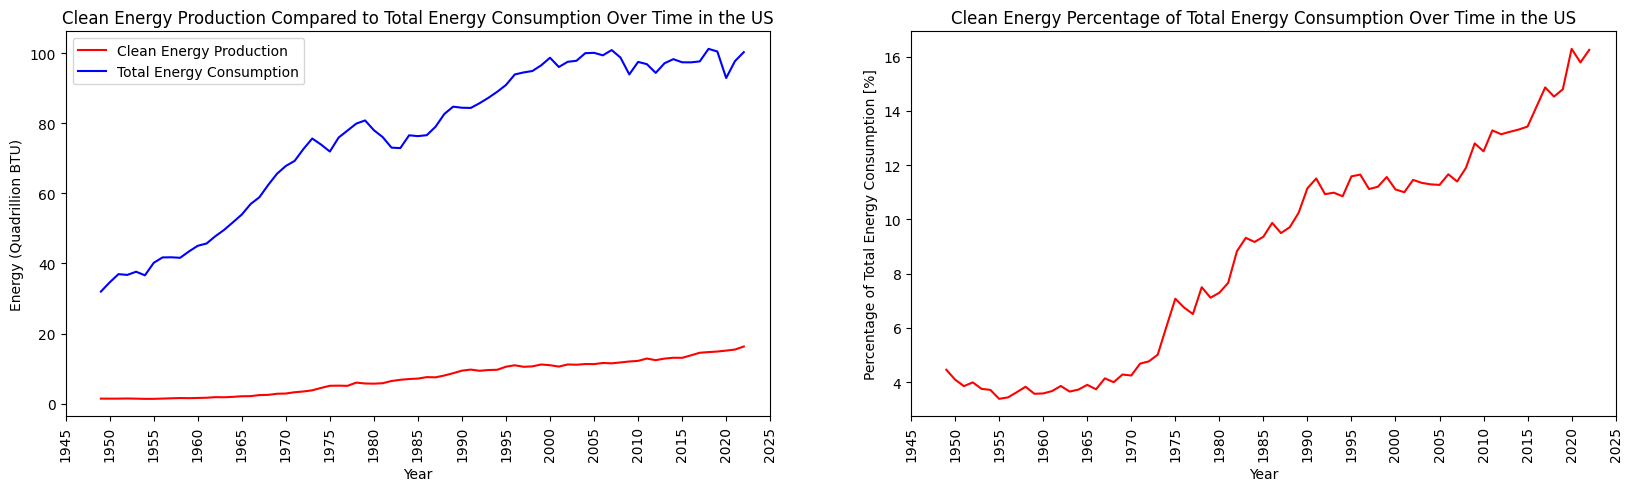

In [4]:
# Create list of energy categorized as clean energy
clean_energy = ['Nuclear', 'Solar', 'Wind', 'Hydroelectric', 'Geothermal', 'Annual Total']

cols = e_production_by_source.columns
cols_to_keep = [col for col in cols for clean in clean_energy if clean in col]

# Create a new dataframe with only the clean energy columns
clean_energy = e_production_by_source[cols_to_keep]

# Change all Not Available to zero
clean_energy = clean_energy.replace('Not Available', 0)

# Cast all values to float
clean_energy = clean_energy.astype(float)

# Create a new column that sums all the clean energy sources
clean_energy['Total'] = clean_energy.sum(axis=1) - clean_energy['Annual Total']

# Create a new column that computes the clean energy percentage of total energy production
clean_energy['Clean_Percentage'] = clean_energy['Total'] / e_consumption_by_source['Total Primary Energy Consumption'] * 100

# Create a 1x2 subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot the clean energy production over time on first subplot
ax[0].plot(clean_energy['Annual Total'], clean_energy['Total'], color='r', label='Clean Energy Production')
ax[0].plot(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], color='b', label='Total Energy Consumption')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Energy (Quadrillion BTU)')
ax[0].legend()
ax[0].set_xlim(1945, 2025)
ax[0].set_xticks(np.arange(1945, 2026, 5))
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Clean Energy Production Compared to Total Energy Consumption Over Time in the US')

# Plot clean energy production as a percentage of total energy consumption on second subplot
ax[1].plot(clean_energy['Annual Total'], clean_energy['Clean_Percentage'], color='r', label='Clean Energy Production')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Percentage of Total Energy Consumption [%]')
ax[1].set_xlim(1945, 2025)
ax[1].set_xticks(np.arange(1945, 2026, 5))
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('Clean Energy Percentage of Total Energy Consumption Over Time in the US')

plt.show()


**Assumptions of the Preceding Plots**
<div class="alert alert-block alert-info">
Based on the shape of the total energy consumption data, we decided to use a special function for curve fitting this data called a hill sigmoid function. The reason we chose this is because the total energy consumption data initially takes on a quadratic- or exponential-like shape but then tapers off, seeming to approach a horizontal asymptote. This shape is exactly how a hill sigmoid function behaves, however this choice does inherently assume that there will be some eventual maximum power which will ever be produced in the US as time goes on. While it is possible for a trend like this to occur in the near term, it seems unreasonable to us to assume that no new breakthrough technologies in energy production will ever occur to allow for substantially higher energy production - meaning our confidence in the analysis we are making drops off significantly the farther out our predictions are extrapolated.
</div>

In [5]:
# Define a Hill sigmoidal function to use for curve fitting later
def hill_sigmoid(x, a, b, c):
    return  a * np.power(x, b) / (np.power(c, b) + np.power(x, b)) 

<div class="alert alert-block alert-info">
Based on the shape of the clean energy production data, we decided that 
</div>

In [11]:
# Define an exponential function to use for curve fitting later
def exponential(x, a, b, c):
    return a * b ** x + c

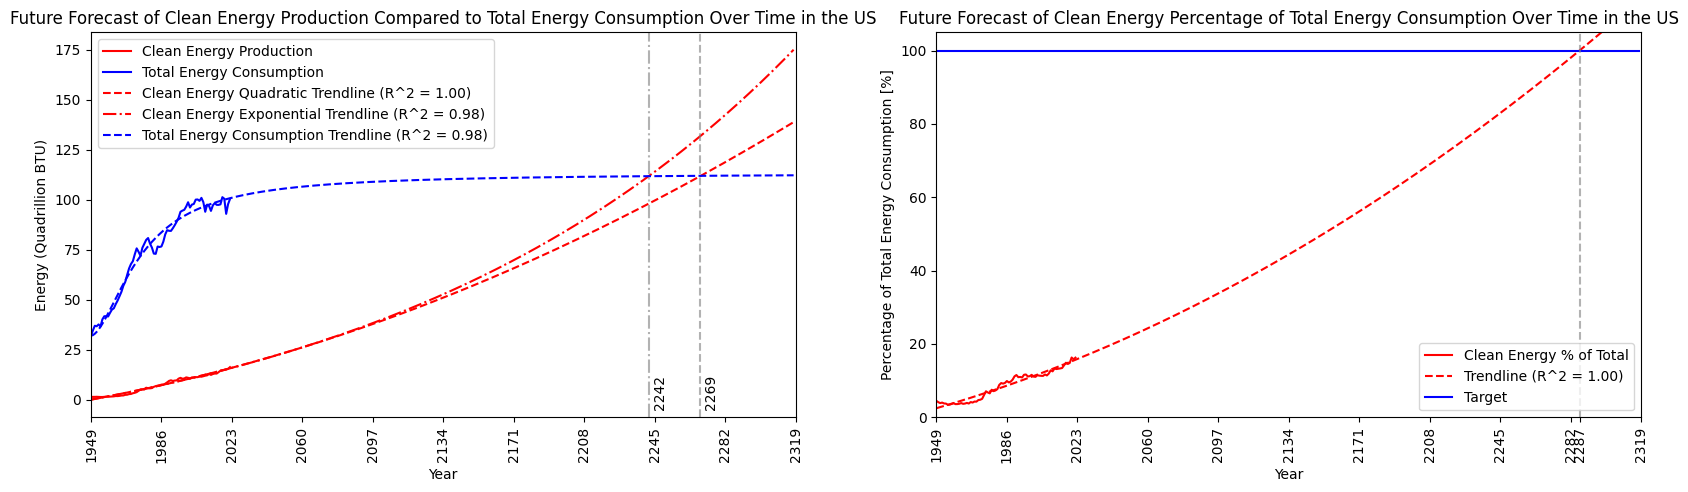

In [30]:
# Create a list of years to forecast trendlines out to 2050
xmin = e_consumption_by_source['Annual Total'][0]
xmax = 2319
future_years = np.arange(xmin, xmax, 1)
future_years_mod = future_years - xmin
ticks = np.arange(xmin, xmax+1, round((xmax - xmin) / 10))

#### Total Energy Consumption ####

# First, set the origin of the data to the first data point (so curve fitting works better)
total_start_energy = e_consumption_by_source['Total Primary Energy Consumption'][0]
total_x_modified   = e_consumption_by_source['Annual Total'] - xmin
total_y_modified   = e_consumption_by_source['Total Primary Energy Consumption'] - total_start_energy

# Perform curve fitting using the logarithmic function defined earlier for total energy consumption
total_popt, total_pcov = curve_fit(hill_sigmoid, total_x_modified, total_y_modified, p0=[1, 1, 1])

# Store the values of the curve fit extrapolated out to the final date set above
total_val_predictive = hill_sigmoid(future_years_mod, *total_popt) + total_start_energy

# Compute the R^2 value of the curve fit
total_r_squared = np.corrcoef(total_y_modified, hill_sigmoid(total_x_modified, *total_popt))[0, 1] ** 2

#### Clean Energy Production ####

# First, set the origin of the data to the first data point (so curve fitting works better)
clean_start_energy = clean_energy['Total'][0]
clean_x_modified   = clean_energy['Annual Total'] - xmin
clean_y_modified   = clean_energy['Total'] - clean_start_energy

# Perform curve fitting using the exponential function defined earlier for clean energy production
clean_exp_popt, clean_exp_pcov = curve_fit(exponential, clean_x_modified, clean_y_modified, p0=[1, 1, 1], maxfev=3000)

# Store the values of the curve fit extrapolated out to the final date set above
clean_exp_val_predictive = exponential(future_years_mod, *clean_exp_popt) + clean_start_energy

# Compute the R^2 value of the curve fit
clean_exp_r_squared = np.corrcoef(clean_y_modified, exponential(clean_x_modified, *clean_exp_popt))[0, 1] ** 2

# Create a trendline for the clean energy data as a quadratic polynomial and store the R^2 value
clean_quad_fit            = np.polyfit(clean_energy['Annual Total'], clean_energy['Total'], 2)
clean_quad_r_squared      = np.corrcoef(clean_energy['Annual Total'], np.polyval(clean_quad_fit, clean_energy['Annual Total']))[0, 1] ** 2
clean_quad_val_predictive = np.polyval(clean_quad_fit, future_years)

# Create a trendline for the clean energy perentage as a polynomial and store the R^2 value
predictive_clean_percentage_fit = np.polyfit(clean_energy['Annual Total'], clean_energy['Clean_Percentage'], 2)
r_squared_clean_percentage      = np.corrcoef(clean_energy['Annual Total'], np.polyval(predictive_clean_percentage_fit, clean_energy['Annual Total']))[0, 1] ** 2
predictive_clean_percentage_val = np.polyval(predictive_clean_percentage_fit, future_years)

# Create a trendline for the clean energy perentage as an exponential function


#### Left Plot ####

# Create a 1x2 subplot
fig2, ax2 = plt.subplots(1, 2, figsize=(20, 5))

# Plot the trendlines
ax2[0].plot(clean_energy['Annual Total'], clean_energy['Total'], color='r', label='Clean Energy Production')
ax2[0].plot(e_consumption_by_source['Annual Total'], e_consumption_by_source['Total Primary Energy Consumption'], color='b', label='Total Energy Consumption')
ax2[0].plot(future_years, clean_quad_val_predictive, color='r', linestyle='--', label=f'Clean Energy Quadratic Trendline (R^2 = {clean_quad_r_squared:.2f})')
ax2[0].plot(future_years, clean_exp_val_predictive, color='r', linestyle='-.', label=f'Clean Energy Exponential Trendline (R^2 = {clean_exp_r_squared:.2f})')
ax2[0].plot(future_years, total_val_predictive, color='b', linestyle='--', label=f'Total Energy Consumption Trendline (R^2 = {total_r_squared:.2f})')
ax2[0].set_xlabel('Year')
ax2[0].set_ylabel('Energy (Quadrillion BTU)')
ax2[0].legend()
ax2[0].set_xlim(xmin, xmax)
ax2[0].set_xticks(ticks)
ax2[0].tick_params(axis='x', rotation=90)
ax2[0].set_title('Future Forecast of Clean Energy Production Compared to Total Energy Consumption Over Time in the US')

# Get the closest point between quadratic clean energy trendline and total energy consumption trendline and return the year they cross
closest_val_quad = min(abs(total_val_predictive - clean_quad_val_predictive))
cross_year_quad  = future_years[abs(total_val_predictive - clean_quad_val_predictive) == closest_val_quad][0]

# Get the closest point between exponential clean energy trendline and total energy consumption trendline and return the year they cross
closest_val_exp = min(abs(total_val_predictive - clean_exp_val_predictive))
cross_year_exp  = future_years[abs(total_val_predictive - clean_exp_val_predictive) == closest_val_exp][0]

# Add a dotted vertial grey line at the year the trendlines cross with 0.6 transparency
ax2[0].axvline(x=cross_year_quad, color='grey', linestyle='--', alpha=0.6)
ax2[0].axvline(x=cross_year_exp , color='grey', linestyle='-.', alpha=0.6)

# Add the crossing year as text on the plot positioned next to the vertical line
ax2[0].text(cross_year_quad + 2, -5, f'{cross_year_quad:.0f}', rotation=90, verticalalignment='bottom', horizontalalignment='left')
ax2[0].text(cross_year_exp + 2, -5, f'{cross_year_exp:.0f}', rotation=90, verticalalignment='bottom', horizontalalignment='left')

#### Right Plot ####

# Plot the clean energy production as a percentage of total energy consumption trendline
ax2[1].plot(clean_energy['Annual Total'], clean_energy['Clean_Percentage'], color='r', label='Clean Energy % of Total')
ax2[1].plot(future_years, predictive_clean_percentage_val, color='r', linestyle='--', label=f'Trendline (R^2 = {r_squared_clean_percentage:.2f})')
ax2[1].plot(future_years, np.full(len(future_years), 100), color='b', linestyle='-', label=f'Target')
ax2[1].set_xlabel('Year')
ax2[1].set_ylabel('Percentage of Total Energy Consumption [%]')
# Put legend in bottom right corner
ax2[1].legend(loc='lower right')
ax2[1].set_xlim(xmin, xmax)
ax2[1].set_ylim(0, 105)
ax2[1].set_xticks(ticks)
ax2[1].tick_params(axis='x', rotation=90)
ax2[1].set_title('Future Forecast of Clean Energy Percentage of Total Energy Consumption Over Time in the US')

# Get the year when clean energy production is 100% of total energy consumption
closest_val = min(abs(100 - predictive_clean_percentage_val))
clean_100 = future_years[abs(100 - predictive_clean_percentage_val) == closest_val][0]

# Add a dotted vertial grey line at the year when clean energy production is 100% of total energy consumption with 0.6 transparency
ax2[1].axvline(x=clean_100, color='grey', linestyle='--', alpha=0.6)

# Add an additional tick label at the year when clean energy production is 100% of total energy consumption
ax2[1].set_xticks(np.append(ticks, clean_100))

# print(f'Prediction method 1 (trendline crossing) predicts year: {cross_year:.0f}\nPrediction method 2 (clean e percentage) predicts year: {clean_100:.0f}')

plt.show()


**Conclusion**
<div class="alert alert-block alert-info">
INSERT HERE
</div>